In [1]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_image_paths(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Filter only for image files (you can add more extensions if needed)
    image_files = [os.path.join(folder_path, f) for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')) and not f.startswith('.')]
    image_names = [os.path.splitext(f)[0] for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', 'gif')) and not f.startswith('.')]
    if not image_files:
        print(f"No image files found in {folder_path}")

    return image_files, image_names

def display_images_in_jupyter(image_paths, columns=2):
    if not image_paths:
        print("No images to display.")
        return

    total_images = len(image_paths)
    rows = -(-total_images // columns)  # Calculate number of rows needed

    # Create a grid to display images
    fig, axes = plt.subplots(rows, columns, figsize=(12, 8))
    axes = axes.flatten()

    for i, image_path in enumerate(image_paths):
        if i >= total_images:
            break

        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')

    # Remove empty subplots
    for i in range(total_images, rows * columns):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [2]:
dev_folder_path = "/kaggle/input/2024-sum-dpl-302-m/devset_images/devset_images"
test_folder_path = "/kaggle/input/2024-sum-dpl-302-m/testset_images/testset_images"
dev_image_paths = get_image_paths(dev_folder_path)[0]
test_image_paths = get_image_paths(test_folder_path)[0]
print(len(dev_image_paths))
print(len(test_image_paths))

5280
1320


In [3]:
def images_to_numpy_array(image_paths, image_size=(500,375)):
    return [np.array(Image.open(image_path).resize(image_size)) for image_path in image_paths]
dev_image_arrays = images_to_numpy_array(dev_image_paths)
test_image_arrays = images_to_numpy_array(test_image_paths)

array([[[ 58,  91, 124],
        [ 58,  91, 126],
        [ 57,  91, 126],
        ...,
        [ 49,  82, 117],
        [ 49,  82, 117],
        [ 49,  82, 117]],

       [[ 58,  91, 124],
        [ 58,  91, 126],
        [ 56,  90, 125],
        ...,
        [ 49,  82, 117],
        [ 49,  82, 117],
        [ 49,  82, 117]],

       [[ 59,  92, 126],
        [ 57,  91, 126],
        [ 57,  91, 126],
        ...,
        [ 49,  82, 117],
        [ 49,  82, 117],
        [ 49,  82, 117]],

       ...,

       [[ 49,  67, 104],
        [ 47,  67, 101],
        [ 49,  69, 102],
        ...,
        [ 48,  71, 102],
        [ 48,  71, 103],
        [ 49,  72, 103]],

       [[ 51,  69, 105],
        [ 50,  70, 103],
        [ 51,  71, 104],
        ...,
        [ 45,  68, 100],
        [ 44,  67,  99],
        [ 43,  66,  98]],

       [[ 49,  69, 104],
        [ 48,  68, 101],
        [ 49,  70, 101],
        ...,
        [ 44,  68, 102],
        [ 43,  68,  99],
        [ 44,  69, 100]]

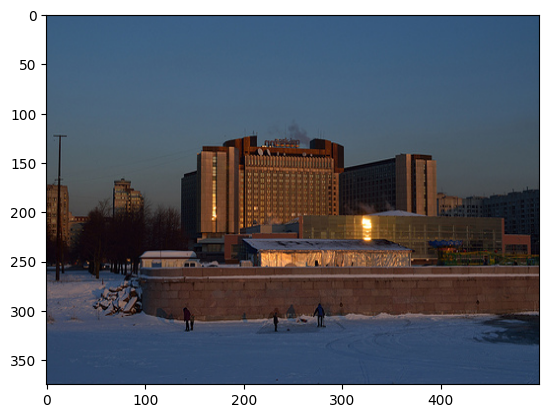

In [16]:
plt.imshow(dev_image_arrays[2])
dev_image_arrays[2]

In [5]:
from collections import Counter

# # Flatten the list of shapes
dev_shapes = [tuple(arr.shape) for arr in dev_image_arrays]
test_shapes = [tuple(arr.shape) for arr in test_image_arrays]

In [6]:
dev_shape_counter = Counter(dev_shapes)
dev_shape_counter.most_common(1)

[((375, 500, 3), 5280)]

In [7]:
test_shape_counter = Counter(test_shapes)
test_shape_counter.most_common(1)

[((375, 500, 3), 1320)]

In [8]:
dev_df = pd.read_csv("/kaggle/input/2024-sum-dpl-302-m/devset_images_gt.csv")
sorted_df = dev_df.sort_values(by="id")
array_sorted_df = np.array(sorted_df["id"])
array_sorted_df, array_sorted_df.shape

(array([     224249,      228743,      473932, ..., 13948706965,
        13989148346, 14006803563]),
 (5280,))

In [9]:
dev_image_names = np.array(get_image_paths(dev_folder_path)[1], dtype="int64")
test_image_names = np.array(get_image_paths(test_folder_path)[1], dtype="int64")
dev_image_names, dev_image_names.shape

(array([6099582129, 2481944299, 6820987318, ..., 3207715884, 6080576417,
        4656252409]),
 (5280,))

In [10]:
all(np.sort(dev_image_names) == array_sorted_df)

True

In [11]:
dev_image_vectors = [image.reshape(-1) for image in dev_image_arrays]

In [12]:
dict1 = dict(zip(dev_image_names, dev_image_arrays))

In [13]:
dict2 = dev_df.set_index('id')['label'].to_dict()

In [14]:
merged_dict = {k: (v, dict2[k]) for k, v in dict1.items() if k in dict2}
X_train = np.array([item[0] for item in merged_dict.values()])
Y_train = np.array([item[1] for item in merged_dict.values()]).reshape(-1,)

In [15]:
X_train.shape, Y_train.shape

((5280, 375, 500, 3), (5280,))

# Training the model

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small, ResNet50, InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB4, EfficientNetB3,EfficientNetB5
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomWidth, RandomHeight, RandomZoom, RandomContrast,Conv2D,Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Input, Lambda, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, LayerNormalization
from tensorflow.keras.applications.convnext import ConvNeXtBase
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import TruncatedNormal

2024-06-08 10:45:39.454942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 10:45:39.455004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 10:45:39.456531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.02))
#     data_augmentation.add(RandomWidth(0.01))
#     data_augmentation.add(RandomHeight(0.01))
    data_augmentation.add(RandomContrast(0.2))
    return data_augmentation

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dropout, Dense
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import RandomFlip, RandomRotation

# Define the model function
def get_model(model_name, input_shape, fine_tune_at, data_augmenter=data_augmenter(), preprocess_input=preprocess_input):
    base_model = model_name(weights="imagenet",
                            include_top=False,
                            input_shape=input_shape,
                            pooling="max"
                            )
    # base_model.trainable = False
    print(len(base_model.layers))
    for layer in base_model.layers[:fine_tune_at]:
# #     for layer in base_model.layers[:455]:
        layer.trainable = False  # You can customize this based on your requirements
    #base_model.trainable = False
    model = tf.keras.Sequential([
        Input(shape=input_shape),
        data_augmenter,
        Lambda(preprocess_input),
        base_model,
        Dropout(0.5, seed=1),
        Dense(1, activation='sigmoid')
    ])

    return model

In [21]:
# Define input shape and learning rate
base_learning_rate = 0.001
input_shape = (375, 500, 3)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Get the model
model = get_model(EfficientNetB4, input_shape, fine_tune_at=455)

# Define the loss function, optimizer, and metrics
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.1)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001 * base_learning_rate)
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.01 * base_learning_rate, weight_decay=1e-4)
metric = tf.keras.metrics.BinaryAccuracy()

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=[metric])

# Assuming X_train and Y_train are already defined and loaded
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model.summary()

476


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 375, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 375, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,793 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,675,616 (67.43 MB)

 Trainable params: 4,589,425 (17.51 MB)

 Non-trainable params: 13,086,191 (49.92 MB)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.weights.h5',
    save_weights_only=True,          
    save_best_only=False,            
    save_freq='epoch'                
)

In [44]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=8, validation_split=0.01, callbacks=[early_stopping])

# train_batch_size = 8
# validation_batch_size = 16

# history = model.fit(
#     X_train,
#     Y_train,
#     epochs=30,
#     batch_size=train_batch_size,
#     validation_split=0.05,
#     validation_batch_size=validation_batch_size,
#     callbacks=[early_stopping]
# )

Epoch 1/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 80s 122ms/step - binary_accuracy: 0.9640 - loss: 0.2836 - val_binary_accuracy: 0.9245 - val_loss: 0.3189
Epoch 2/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 80s 122ms/step - binary_accuracy: 0.9680 - loss: 0.2808 - val_binary_accuracy: 0.9245 - val_loss: 0.3217
Epoch 3/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 79s 122ms/step - binary_accuracy: 0.9698 - loss: 0.2769 - val_binary_accuracy: 0.9245 - val_loss: 0.3182
Epoch 4/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 80s 122ms/step - binary_accuracy: 0.9684 - loss: 0.2814 - val_binary_accuracy: 0.9245 - val_loss: 0.3226
Epoch 5/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 80s 122ms/step - binary_accuracy: 0.9677 - loss: 0.2782 - val_binary_accuracy: 0.9245 - val_loss: 0.3289
Epoch 6/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 79s 121ms/step - binary_accuracy: 0.9703 - loss: 0.2790 - val_binary_accuracy: 0.9245 - val_loss: 0.3273
Epoch 7/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 80s 122ms/step - binary_accuracy: 0.9670 - loss: 0.2785 - val_binary_accuracy: 0.9057 - va

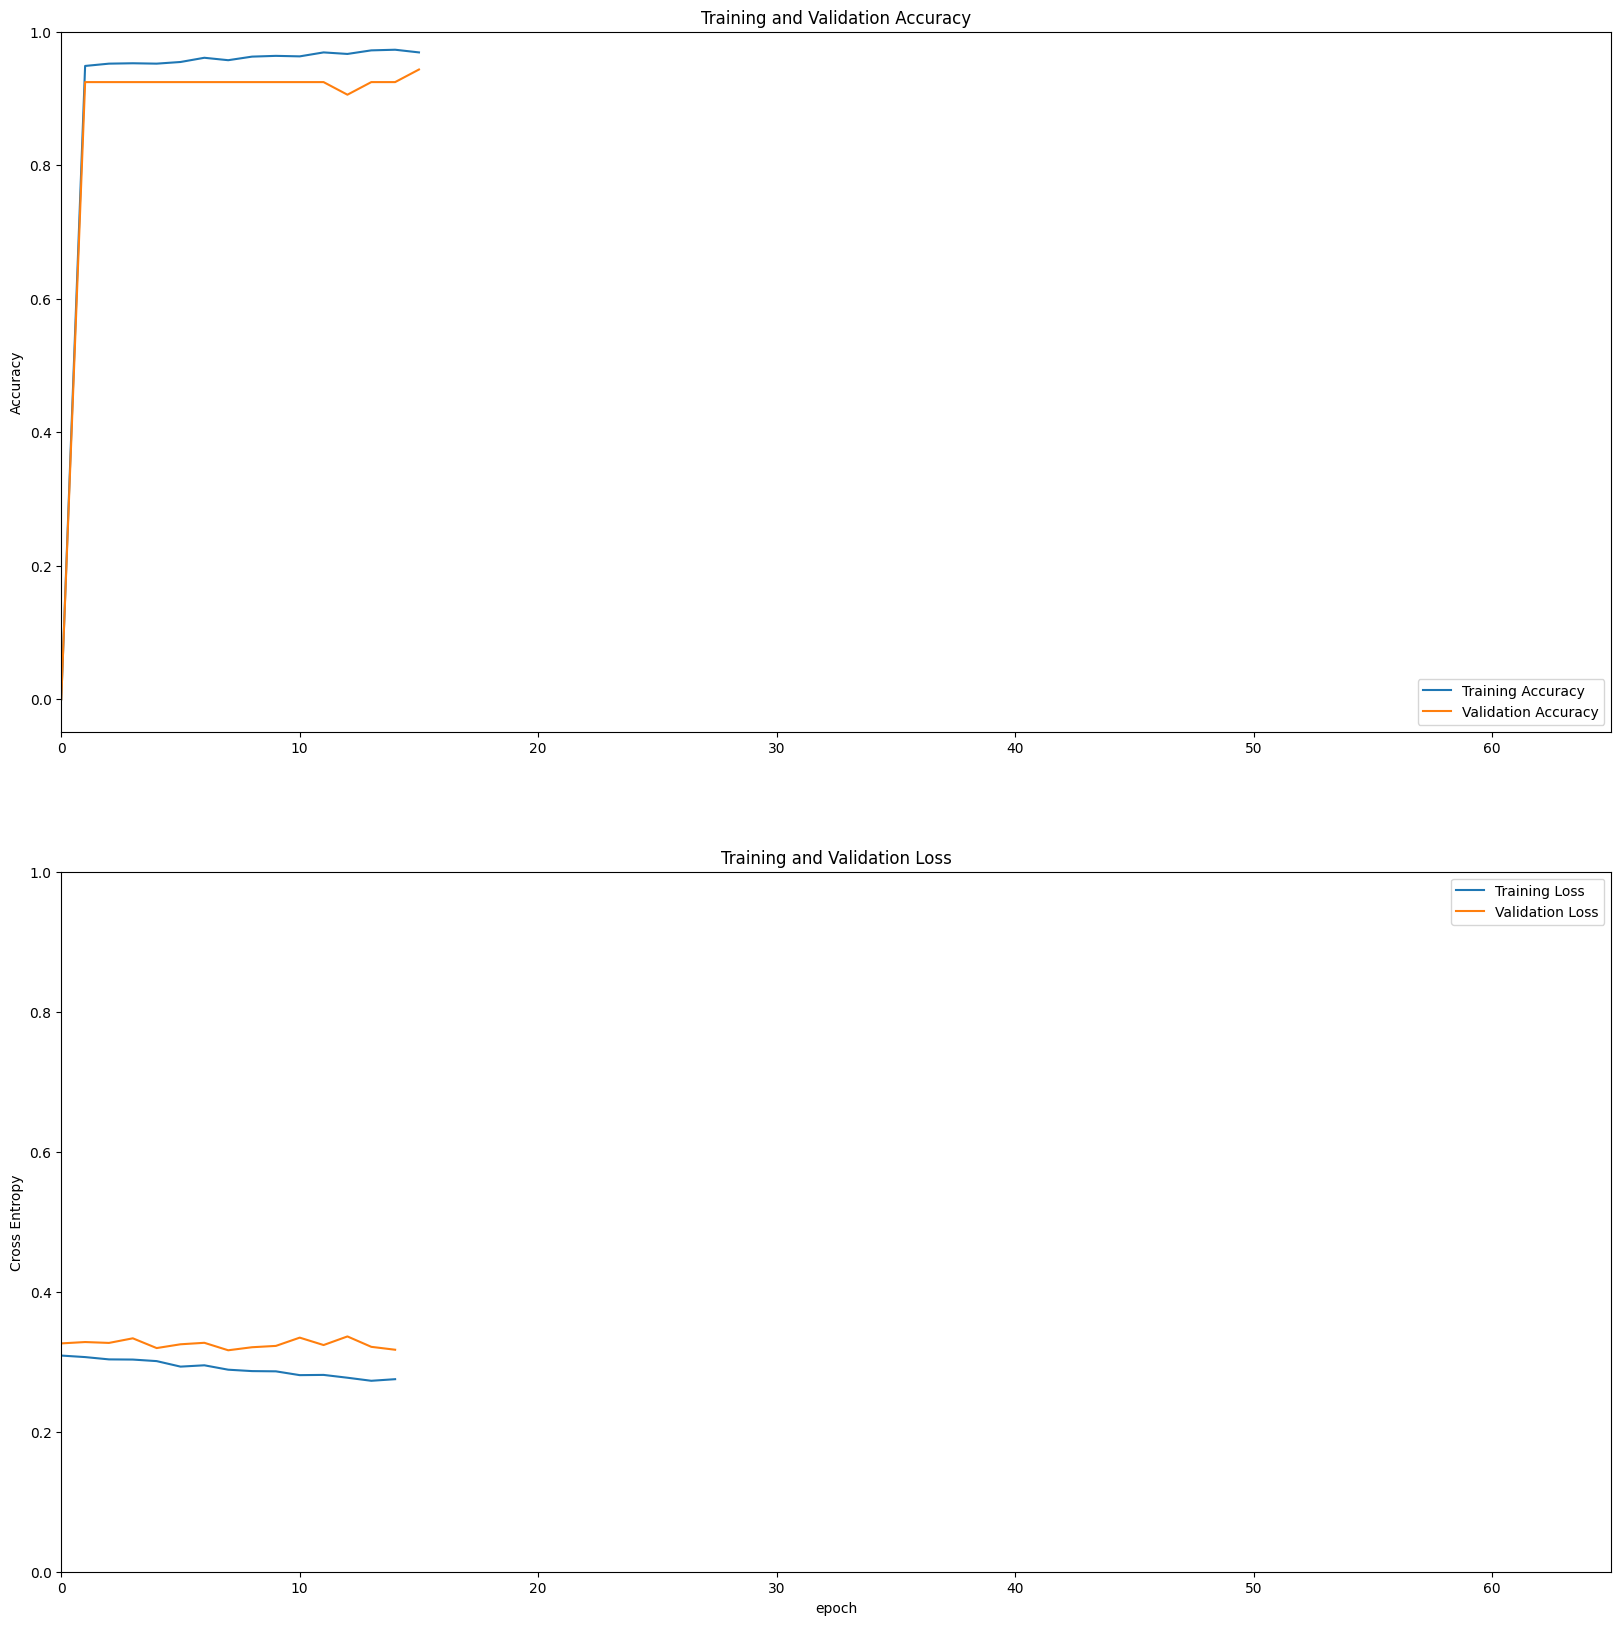

In [27]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.plot([0.] + history.history["binary_accuracy"], label='Training Accuracy')
plt.plot([0.] + history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlim([0, 65])
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlim([0, 65])
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [45]:
X_test = np.array(test_image_arrays); X_test.shape

(1320, 375, 500, 3)

In [46]:
X_train.shape

(5280, 375, 500, 3)

In [47]:
np.unique(Y_train, return_counts=True)

(array([0, 1]), array([3360, 1920]))

In [48]:
Y_test = (model.predict(X_test) > 0.6).astype(int).reshape(-1)
np.unique(Y_test, return_counts=True)

42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 359ms/step


(array([0, 1]), array([909, 411]))

In [49]:
import random

# Combine X_test and Y_test into a list of tuples
data = list(zip(X_test, Y_test))

# Randomly shuffle the list of tuples
selected_data = random.sample(data, 700)

# Unzip the selected data back into separate lists
X_selected, binary_selected = zip(*selected_data)

# Convert them to numpy arrays
X_selected, binary_selected = np.array(X_selected), np.array(binary_selected)

In [50]:
random_700_test = np.random.choice(Y_test, 700, replace=False);random_700_test.shape, Y_test.shape

((700,), (1320,))

In [ ]:
# random_700_test = np.random.choice(X_test, 700, replace=False, axis = 0);random_700_test.shape, Y_test.shape

In [51]:
random_indices = np.random.choice(X_test.shape[0], 700, replace=False)
random_700_test = X_test[random_indices]
random_700_test.shape, Y_test.shape

((700, 375, 500, 3), (1320,))

In [58]:
Y_train_new = (model.predict(X_train) > 0.4).astype(int).reshape(-1)

165/165 ━━━━━━━━━━━━━━━━━━━━ 59s 358ms/step


In [59]:
data_original = pd.DataFrame({
    "id": dev_image_names,
    "label_original": Y_train,
    "label_new": Y_train_new
}); data_original

,id,label_original,label_new
0,6099582129,1,1
1,2481944299,1,1
2,6820987318,0,0
3,864584409,1,1
4,9349393459,0,0
...,...,...,...
5275,4142771417,1,1
5276,5743388887,0,0
5277,3207715884,1,1
5278,6080576417,0,0


In [60]:
different_labels = data_original[data_original['label_original'] != data_original['label_new']]; different_labels

,id,label_original,label_new
691,5382670230,1,0
692,291394594,0,1
1159,94743149,1,0
1280,5254218997,0,1
1892,2857854229,1,0
2377,5134684581,1,0
2431,4239582572,0,1
2474,2140567158,1,0
3556,3337708392,0,1
3903,2528940950,1,0


In [64]:
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.efficientnet import preprocess_input

# # Định nghĩa hàm preprocess_image() để tiền xử lý ảnh
# # def preprocess_image(img_path, target_size=(500, 375)):
# #     img = image.load_img(img_path, target_size=target_size)
# #     img_array = image.img_to_array(img)
# #     img_array = preprocess_input(img_array)
# #     return img_array

# Định nghĩa hàm predict_label() để dự đoán nhãn cho ảnh
def predict_label(model, img):
    # Đảm bảo ảnh có kích thước phù hợp với đầu vào của mô hình
    img = np.expand_dims(img, axis=0)
    # Dự đoán nhãn với mô hình
    predicted_prob = model.predict(img)
    # Chuyển đổi xác suất thành nhãn
    predicted_label = (predicted_prob >= 0.45).astype(int)
    return predicted_label

In [65]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess_image(img_path, target_size=(375,500)):
    try:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

def threshold_label(label, threshold=0.45):
    if label >= threshold:
        return 1
    else:
        return 0

# Đường dẫn đến thư mục chứa ảnh kiểm tra
test_img_folder = "/kaggle/input/2024-sum-dpl-302-m/testset_images/testset_images"

# Tạo list để lưu kết quả
results = []

# Lặp qua tất cả các tệp trong thư mục "Test_img"
for filename in os.listdir(test_img_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(test_img_folder, filename)
        img = preprocess_image(img_path)
        if img is not None:
            img_array = np.expand_dims(img, axis=0)  # Thêm chiều batch_size
            # Dự đoán nhãn với mô hình
            predicted_prob = model.predict(img_array)  # Chạy mô hình với ảnh img_array
            # Chuyển đổi xác suất thành nhãn
            predicted_label = (predicted_prob >= 0.45).astype(int)
            # Thêm kết quả vào list
            results.append({'id': filename, 'label': predicted_label[0][0]})
        else:
            print(f"Skipping file {filename} due to loading error.")

# Tạo DataFrame từ list kết quả
test_results_df = pd.DataFrame(results)

# Xuất kết quả thành tệp CSV
test_results_df.to_csv("/kaggle/working/_Never_give_up_up_.csv", index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Error loading image /kaggle/input/2024-sum-dpl-302-m/testset_images/testset_images/._5705255339.jpg: cannot identify image file <_io.BytesIO object at 0x7986a5e76ed0>
Skipping file ._5705255339.jpg due to loading error.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Error loading image /kaggle/input/2024-sum-dpl-302-m/testset_images/testset_images/._3951602623.jpg: cannot identify image file <_io.BytesIO object at 0x7986a6b74180>
Skipping file ._3951602623.jpg due to loading error.
Error loading image /kaggle/input/2024-sum-dpl-302-m/testset_images/testset_images/._7591858812.jpg: cannot identify image file <_io.BytesIO object at 0x7986a6b74180>
Skipping file ._7591858812.jpg due to loading error.
Error loading image /kaggle/input/2024-sum-dpl-302-m/testset_images/testset_images/._8688852154.jpg: cannot identify image file <_io.BytesIO object at 0x7986a6b74180>
Skipping file ._8688852154.jpg due to loading error.
Error 

In [66]:
import pandas as pd

# Đọc file CSV vào DataFrame
df = pd.read_csv("/kaggle/working/_Never_give_up_up_.csv")

# Loại bỏ đuôi .jpg từ cột id
df['id'] = df['id'].str.replace('.jpg', '').str.replace('.png', '')
# Loại bỏ các kí tự "[" và "]" từ cột label
# df['label'] = df['label'].str.replace('[', '').str.replace(']', '')

# Lưu DataFrame đã được chỉnh sửa thành file CSV mới
df.to_csv("/kaggle/working/Never_give_up_21.csv", index=False)

In [136]:
# Lưu trọng số của mô hình
model.save_weights('model_.weights.h5')
